

# Dogecoin price prediction with Gaussian Process

Dogecoin price prediction based on the past 6 months data using non-parametric gaussian process (GP). GPy library is used for the implementation and optimisation. Choosing the right kernel is the main crux of using GPs. I tried a combination of linear, exponential and periodic kernels to get the best result[Lot more to improve!!]. Due to stochastic nature of the the time series, I though may be brownian kernel would be better but didn't work out well. Predicting the missing values in the data seems to work better than predicting future after a certain time point. Regardless, I learnt a bit more about Gaussian Processes which had been elusive to me for many years. 

* Dogecoin price data is extracted using `CoinGeckoAPI`

> Here I use Gaussian process to predic the stock price of Dogecoin. 

In [2]:
#install few packages
#!pip install pycoingecko
#!pip install plotly
#!pip install mplfinance
#!pip install GPy

Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import plot
import datetime
from pycoingecko import CoinGeckoAPI
from mplfinance.original_flavor import candlestick2_ohlc

### Rest APIs function --> sending request via HTTP message.

Lets use CoinGeckoAPI to get dogecoin data

Lets start off by getting the data we need. Using the `get_coin_market_chart_by_id(id, vs_currency, days)`. id is the name of the coin we want, vs_currency is the currency you want the price in, and days is how many days back from today you want.



In [4]:
cg = CoinGeckoAPI()
#cg.get_coins_list()

dogecoin_data = cg.get_coin_market_chart_by_id(id='dogecoin', vs_currency = 'usd', days=360)
#dogecoin_data = cg.get_coin_history_by_id(id='dogecoin', vs_currency = 'usd', date = '21-09-2021')

In [5]:
dogecoin_data.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

In [9]:
dogecoin_data['prices'][0:10]

[[1602115200000, 0.002585135768838736],
 [1602201600000, 0.002593557982389598],
 [1602288000000, 0.0026617601460024063],
 [1602374400000, 0.0026559186073604048],
 [1602460800000, 0.0026683127406620676],
 [1602547200000, 0.002679869448165432],
 [1602633600000, 0.0026374022396522413],
 [1602720000000, 0.002648955090012703],
 [1602806400000, 0.002590363216464035],
 [1602892800000, 0.0026057008823055713]]

### Convert the dic to panda dataframe

In [10]:
#convert into panda dataframe
dogecoin_price_data = dogecoin_data['prices']
doge_data = pd.DataFrame(dogecoin_price_data, columns=['TimeStamp', 'Price'])

In [11]:
doge_data.head()

,TimeStamp,Price
0,1602115200000,0.002585
1,1602201600000,0.002594
2,1602288000000,0.002662
3,1602374400000,0.002656
4,1602460800000,0.002668


checking for null values

In [13]:
doge_data.isnull().sum()

TimeStamp    0
Price        0
dtype: int64

Convert the timestamp and save it to a new column as `Date`. We will map `unix_to_datetime` to each timestamp and convet it to a readable date time

In [14]:
doge_data['date'] = doge_data['TimeStamp'].apply(lambda d: datetime.date.fromtimestamp(d/1000.0))

In [15]:
doge_data.head()

,TimeStamp,Price,date
0,1602115200000,0.002585,2020-10-08
1,1602201600000,0.002594,2020-10-09
2,1602288000000,0.002662,2020-10-10
3,1602374400000,0.002656,2020-10-11
4,1602460800000,0.002668,2020-10-12


Using this modified dataset we can now group by the `Date` and find the min, max, open and close for the candlesticks.

In [16]:
candlestick_data = doge_data.groupby(doge_data.date, as_index=False).agg({"Price":['min','max','first','last']}) #aggregate function
candlestick_data.head()

date     Price                              
                    min       max     first      last
0  2020-10-08  0.002585  0.002585  0.002585  0.002585
1  2020-10-09  0.002594  0.002594  0.002594  0.002594
2  2020-10-10  0.002662  0.002662  0.002662  0.002662
3  2020-10-11  0.002656  0.002656  0.002656  0.002656
4  2020-10-12  0.002668  0.002668  0.002668  0.002668

For some reason, if I go more than 100 days back in the future, figure wont show candle stick. Regardless, we can see the trend of the price. 

In [20]:
fig = go.Figure (data=[go.Candlestick(x=candlestick_data['date'],
                open=candlestick_data['Price']['first'], 
                high=candlestick_data['Price']['max'],
                low=candlestick_data['Price']['min'], 
                close=candlestick_data['Price']['last'])
                ])

fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

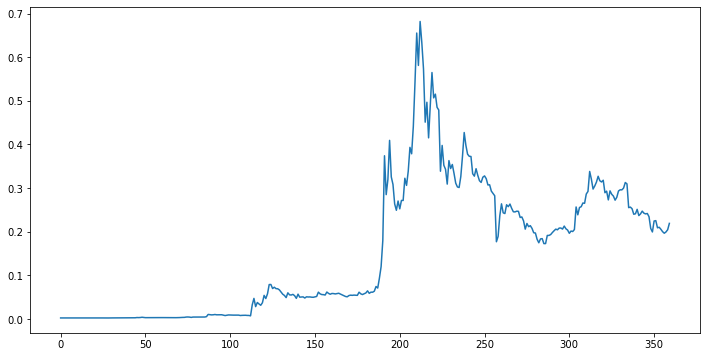

In [21]:
ax = plt.figure(figsize = (12,6))
plt.plot( candlestick_data['Price']['last'], '-')

In [22]:
#extract data index 
data_index =  candlestick_data.index + 1
closing_price = candlestick_data['Price']['last']


Lets create a new data frame with only data index in days and the closing price for each day

In [23]:
doge_dict = {'dataindex': data_index, 'closing price': closing_price}
doge_df = pd.DataFrame(data = doge_dict)
doge_df.head()

,dataindex,closing price
0,1,0.002585
1,2,0.002594
2,3,0.002662
3,4,0.002656
4,5,0.002668


Now we have a time series data of dogecoin with closing price from the last 1 year. We will use this dataframe as our data to make inference with the GPs. For that, we take this data and split it into training and testing points. 

In [24]:
doge_df.describe()

,dataindex,closing price
count,360.000000,360.000000
mean,180.500000,0.152312
std,104.067286,0.151159
min,1.000000,0.002520
25%,90.750000,0.008248
50%,180.500000,0.068174
75%,270.250000,0.264323
max,360.000000,0.681842


As we can see the mean of the price is not zero. To simplify, we `standardize` the data to have zero mean. This can be done by subtracting the mean from each data point. 

In [28]:
price_mean = np.mean(doge_df['closing price'])
doge_df['closing price'] = doge_df['closing price'] - price_mean
doge_df.describe()

,dataindex,closing price
count,360.000000,360.000000
mean,180.500000,0.000000
std,104.067286,0.151159
min,1.000000,-0.149793
25%,90.750000,-0.144064
50%,180.500000,-0.084138
75%,270.250000,0.112010
max,360.000000,0.529529


In [29]:
new_mean = doge_df.describe()['closing price']['mean']

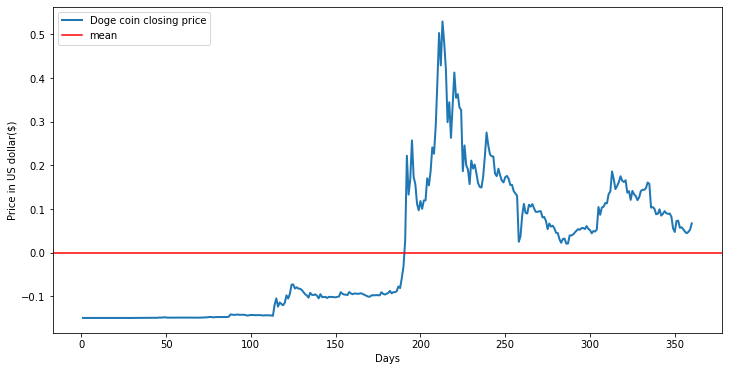

In [30]:
ax = plt.figure(figsize = (12,6))
plt.plot( doge_df['dataindex'], doge_df['closing price'], linewidth = 2.0, label = 'Doge coin closing price')
plt.axhline(y=new_mean, color='r', linestyle='-', label = "mean")
plt.legend(loc = "upper left")
plt.xlabel('Days')
plt.ylabel('Price in US dollar($)')
plt.show()

### Use scikitlearn library to split the data into train and test set

In [31]:
from sklearn.model_selection import train_test_split

In [99]:
#Convert to numpy array and change to a column vector with reshape
X = np.array(doge_df['dataindex']).reshape(-1,1)
y = np.array(doge_df['closing price']).reshape(-1,1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,test_size = 0.2, random_state=42)

In addition to the randomized train and test data, we also want to divide the dataset in a chronological order, to evaluate how well GPs can predict price prediction.

In [100]:
split_ratio=0.9
split_indx=int(len(X)*split_ratio)
X_train2 = X[:split_indx]
X_test2 = X[split_indx:]
y_train2 = y[:split_indx]
y_test2 = y[split_indx:]


### Setting up parameters and kernels for gaussian process

In [34]:
import GPy

# Which kernel to choose? 

I have a composite kernel made up of linear, rbf and periodic. 

In [132]:
RBF = GPy.kern.RBF(input_dim=1)
RBF2 = GPy.kern.RBF(input_dim=1)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=3)
LIN = GPy.kern.Linear(1)
RQ2=GPy.kern.RatQuad(input_dim=1, variance=3)
kern= RBF+LIN+PERIODIC*LIN + RQ2

In [133]:
np.size(X)

360

Text(0.5, 1.0, '10 sampled functions (prior) from a GP')

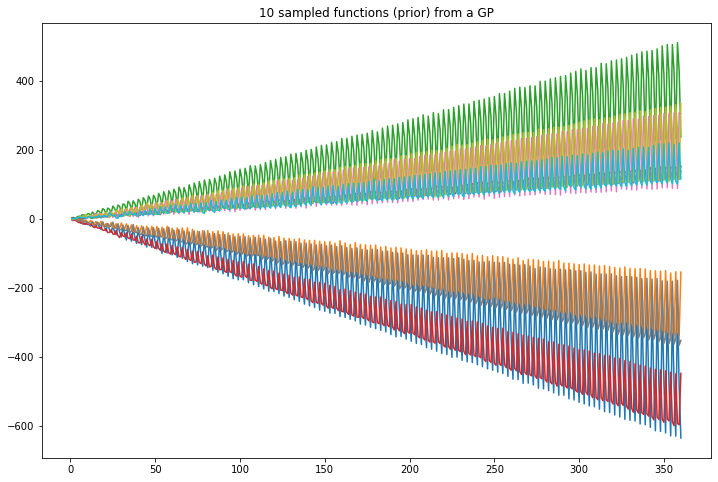

In [134]:
size = np.size(X)
mu = np.zeros((size))
C = kern.K(X,X)
# 500 points evenly spaced over [0,1]
# reshape X to make it n*D
# vector of the means
# covariance matrix
# Generate 20 sample path with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)
plt.figure(figsize = (12,8)) # open new plotting window 
for i in range(10):
    plt.plot(X[:],Z[i,:])
plt.title('10 sampled functions (prior) from a GP')


## Lets optimize the parameterse, find the best lengthscale and variance.  

In [135]:
m = GPy.models.GPRegression(X_train1,y_train1,kern)
m.optimize()
display(m)

GP_regression.,value,constraints,priors
sum.rbf.variance,0.0015505345489914375,+ve,
sum.rbf.lengthscale,2.8838906757836127,+ve,
sum.linear.variances,8.126287223345606e-14,+ve,
sum.mul.periodic_Matern52.variance,0.024283594402921452,+ve,
sum.mul.periodic_Matern52.lengthscale,9.397047398343162,+ve,
sum.mul.periodic_Matern52.period,1.4212433846416257,+ve,
sum.mul.linear.variances,0.024283594464367238,+ve,
sum.RatQuad.variance,0.01931077396378677,+ve,
sum.RatQuad.lengthscale,33.91348553121697,+ve,
sum.RatQuad.power,1.3042221063203672,+ve,


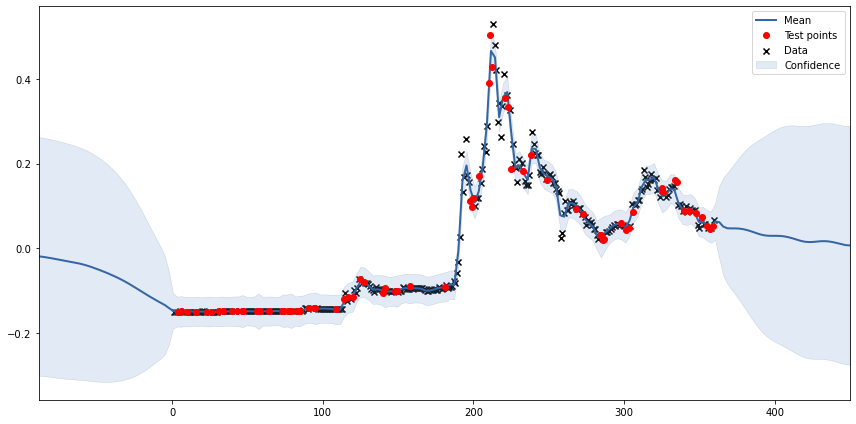

In [136]:
ax = m.plot(figsize = (12,6))
plt.plot(X_test1, y_test1, "ro", mew=1, label='Test points')
plt.legend(loc = 'upper right')

After optimisation, it seems that the test points are right along where the predictive function mean is. Given lots of missing data, GP can be useful to predict the missing data. However, as we can see that after the last data point, the mean predictive function returns back to initial stage. Now, let's see how GPs would learn the mean function for a chronological data.   

{'covariance': [[<matplotlib.lines.Line2D at 0x289821be0>]]}

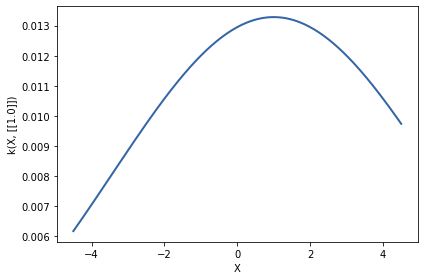

In [127]:
kern.plot()

In [128]:
def visualize_covariance(K):
    """Helper function for visualizing a covariance matrix on the training data."""
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(K, interpolation='None')
    plt.colorbar(im)


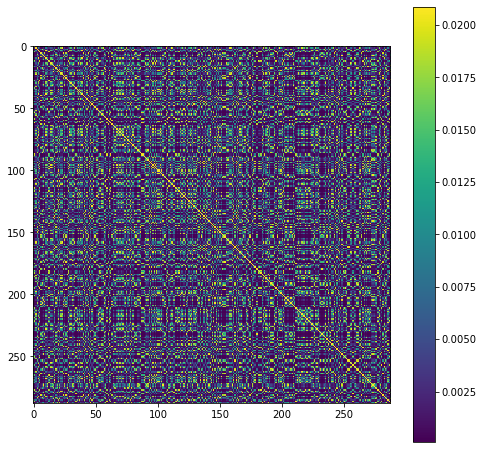

In [137]:
#periodic = GPy.kern.Exponential(input_dim=1)
visualize_covariance(kern.K(X_train1))

### Lets try with predicting the future values, not the mising intermediate values

In [138]:
m1 = GPy.models.GPRegression(X_train2,y_train2,kern)
m1.optimize()
display(m1)

GP_regression.,value,constraints,priors
sum.rbf.variance,0.0018810001276929405,+ve,
sum.rbf.lengthscale,3.2055811953208613,+ve,
sum.linear.variances,8.126286846871665e-14,+ve,
sum.mul.periodic_Matern52.variance,0.051174501877487934,+ve,
sum.mul.periodic_Matern52.lengthscale,8.987895655518669,+ve,
sum.mul.periodic_Matern52.period,1.271883291810769,+ve,
sum.mul.linear.variances,0.05117450200402768,+ve,
sum.RatQuad.variance,0.021045306949777617,+ve,
sum.RatQuad.lengthscale,33.923835730777256,+ve,
sum.RatQuad.power,1.2478965705011653,+ve,


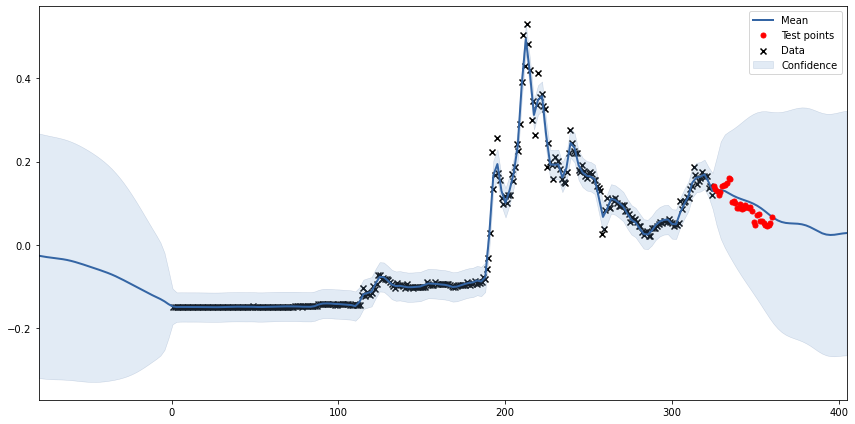

In [139]:

m1.plot(figsize = (12,6))
plt.plot(X_test2, y_test2, "ro", markersize=5, label='Test points')
plt.legend(loc = 'upper right')


Text(0.5, 1.0, 'Covariane matrix - kernel')

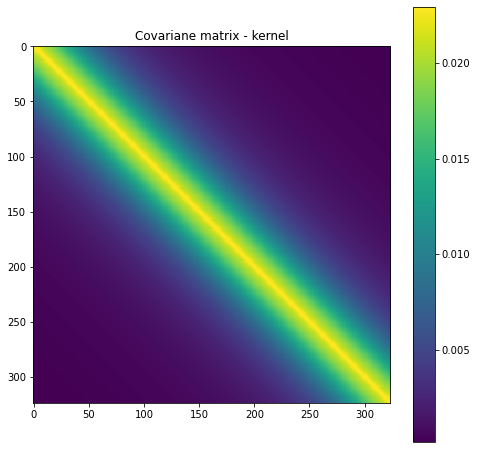

In [140]:
visualize_covariance(kern.K(X_train2))
plt.title('Covariane matrix - kernel')